In [21]:
import pandas as pd
import numpy as np



In [22]:
df = pd.read_csv('VCB Historical Data.csv')

In [23]:
df['Price'] = df['Price'].str.replace(',', '').astype('int64')
df['Open'] = df['Open'].str.replace(',', '').astype(int)
df['High'] = df['High'].str.replace(',', '').astype(int)
df['Low'] = df['Low'].str.replace(',', '').astype(int)
df = df[::-1].reset_index(drop=True)
df.dropna(inplace = True)
del df['Vol.']
del df['Change %']
df

,Date,Price,Open,High,Low,Volume
0,7/1/2009,16524,17207,17207,16251,17960000
1,7/2/2009,15841,16251,16387,15705,4360000
2,7/3/2009,15295,15431,15568,15295,2590000
3,7/6/2009,15978,15295,15978,15295,4520000
4,7/7/2009,15431,15705,15841,15431,3210000
...,...,...,...,...,...,...
3652,2/19/2024,90200,89900,90500,89300,1050000
3653,2/20/2024,91300,90100,91400,89400,1400000
3654,2/21/2024,91200,91700,91700,90500,1370000
3655,2/22/2024,89500,90600,91000,89500,1220000


In [24]:
df.to_csv('Data_cleaned.csv')

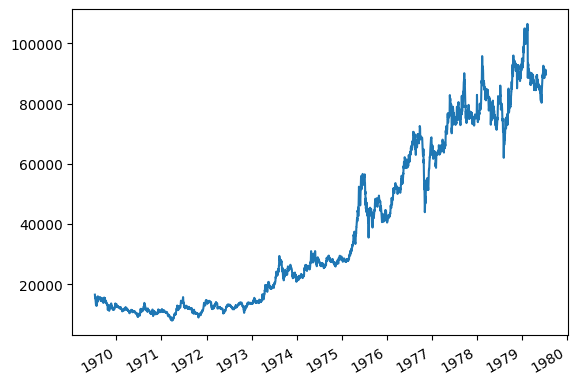

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()
ax.plot(df['Date'], df['Price'], label='Price')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.gcf().autofmt_xdate()

plt.show()


In [26]:
df['Tomorrow'] = df['Price'].shift(-1)
df.dropna(inplace = True)

In [27]:
df['Target'] = (df['Tomorrow'] > df['Price']).astype(int)
df

,Date,Price,Open,High,Low,Volume,Tomorrow,Target
0,7/1/2009,16524,17207,17207,16251,17960000,15841.0,0
1,7/2/2009,15841,16251,16387,15705,4360000,15295.0,0
2,7/3/2009,15295,15431,15568,15295,2590000,15978.0,1
3,7/6/2009,15978,15295,15978,15295,4520000,15431.0,0
4,7/7/2009,15431,15705,15841,15431,3210000,15158.0,0
...,...,...,...,...,...,...,...,...
3651,2/16/2024,89600,89900,90200,89500,734100,90200.0,1
3652,2/19/2024,90200,89900,90500,89300,1050000,91300.0,1
3653,2/20/2024,91300,90100,91400,89400,1400000,91200.0,0
3654,2/21/2024,91200,91700,91700,90500,1370000,89500.0,0


In [28]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = df.iloc[:-100]
test = df.iloc[-100:]  

predictors = ['Price', 'Open', 'High', 'Low' , 'Volume']

model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [29]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
preds

3556    1
3557    1
3558    0
3559    1
3560    1
       ..
3651    0
3652    0
3653    0
3654    0
3655    0
Length: 100, dtype: int32

In [30]:
precision_score(test['Target'], preds)

0.38095238095238093

<Axes: >

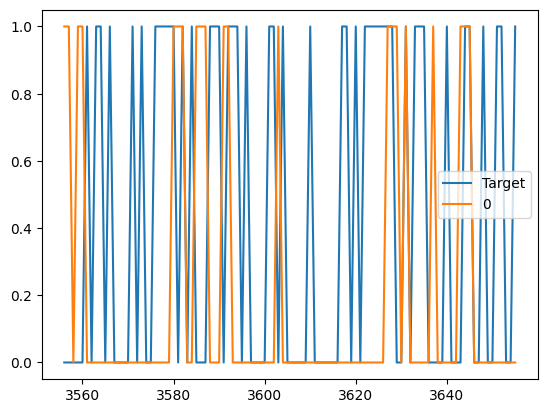

In [31]:
combined = pd.concat([test['Target'], preds], axis=1).dropna()
combined.plot()


In [32]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [33]:
def backtest(data, model, predictors, start=500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [34]:
predictions = backtest(df, model, predictors)


In [35]:
precision_score(predictions['Target'], predictions['Predictions'])

0.4625

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3656 entries, 0 to 3655
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3656 non-null   object 
 1   Price     3656 non-null   int64  
 2   Open      3656 non-null   int32  
 3   High      3656 non-null   int32  
 4   Low       3656 non-null   int32  
 5   Volume    3656 non-null   int64  
 6   Tomorrow  3656 non-null   float64
 7   Target    3656 non-null   int32  
dtypes: float64(1), int32(4), int64(2), object(1)
memory usage: 199.9+ KB


In [38]:
horizons = [2,5,20,60,250]
new_predictors = []
new_df = df.copy()
df = new_df[['Price', 'Open', 'High', 'Low', 'Volume','Tomorrow' ,'Target' ]].copy()

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Price"] / rolling_averages["Price"]
    
    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [39]:
df['Date'] = new_df['Date']

In [40]:
df = df.dropna(subset=df.columns[df.columns != "Tomorrow"])
df

,Price,Open,High,Low,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_20,Trend_20,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Date
250,12333,12273,12333,11944,1320000,11824.0,0,0.997573,1.0,1.026911,2.0,1.050789,10.0,1.042597,24.0,0.936843,97.0,6/30/2010
251,11824,12123,12273,11824,106300,11794.0,0,0.978930,0.0,0.986995,2.0,1.005968,10.0,1.000551,23.0,0.899276,97.0,7/1/2010
252,11794,11974,11974,11674,254710,11914.0,1,0.998730,0.0,0.980089,2.0,1.002652,9.0,0.998960,23.0,0.897951,97.0,7/2/2010
253,11914,11854,11914,11764,391820,11704.0,0,1.005062,1.0,0.988582,2.0,1.010410,10.0,1.009831,24.0,0.908211,97.0,7/5/2010
254,11704,11734,11974,11674,150000,11674.0,0,0.991108,1.0,0.982390,1.0,0.990966,10.0,0.992864,24.0,0.893218,97.0,7/6/2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651,89600,89900,90200,89500,734100,90200.0,1,0.998329,0.0,0.997773,1.0,0.988962,8.0,1.033985,26.0,0.988606,123.0,2/16/2024
3652,90200,89900,90500,89300,1050000,91300.0,1,1.003337,1.0,1.004007,2.0,0.995475,8.0,1.039989,27.0,0.995349,123.0,2/19/2024
3653,91300,90100,91400,89400,1400000,91200.0,0,1.006061,2.0,1.012195,3.0,1.006893,9.0,1.051621,27.0,1.007599,123.0,2/20/2024
3654,91200,91700,91700,90500,1370000,89500.0,0,0.999452,1.0,1.008403,2.0,1.005624,8.0,1.049543,26.0,1.006628,122.0,2/21/2024


In [41]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)


In [42]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [44]:
predictions = backtest(df, model, new_predictors)
predictions["Predictions"].value_counts()


Predictions
0.0    2844
1.0      62
Name: count, dtype: int64

In [45]:
precision_score(predictions["Target"], predictions["Predictions"])


0.6774193548387096